In [1]:
#import libraries
import pandas as pd
from pandas.plotting import scatter_matrix
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [2]:
from sklearn.base import TransformerMixin, BaseEstimator
from sklearn.preprocessing import StandardScaler, OneHotEncoder
import numpy as np

In [3]:
#import data without categories
trees_df = pd.read_csv('county_tree_temp_dwp_prcp_Kent.csv')

In [4]:
trees_df.Biomass.max()

400528.34831446403

## Initial Scatter Matrix

<Figure size 720x720 with 0 Axes>

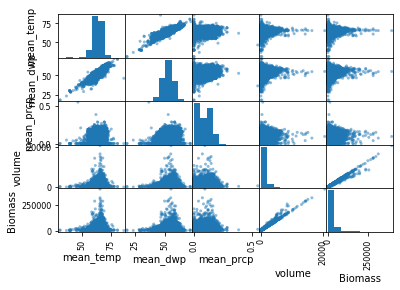

In [58]:
#Dividing up the the data between features and targets
X = trees_df[['species','latitude','longitude','mean_temp','mean_dwp','mean_prcp']]
yb = trees_df['Biomass']
X_train, X_test, y_train, y_test = train_test_split(X, yb, test_size=0.3, shuffle=True, random_state=42)
plt.figure(figsize = (10,10))
scatter_matrix(trees_df[['mean_temp','mean_dwp','mean_prcp','volume','Biomass']].loc[trees_df.species == 'loblolly pine'])
plt.show()

In [59]:
columns = ['year','state_code','county_code','species','latitude',
           'longitude','volume','Biomass','number_trees','mean_temp',
           'mean_dwp','mean_prcp']
trees_no_time = trees_df.copy()
trees_no_time = trees_no_time[columns[3:]]

## Transformer Classes

In [5]:
#creating transformers 
class Scaler(BaseEstimator, TransformerMixin):
    def __init__(self, columns):
        self.scaler = StandardScaler()
        self.columns = columns
    def fit(self,X,y=None):
        if len(X[self.columns].shape) == 1:
            Xreshape = X[self.columns].to_numpy().reshape(-1,1)
            self.scaler.fit(Xreshape)
        else:
            self.scaler.fit(X[self.columns])
        return self
    def transform(self,X,y=None):
        if len(X[self.columns].shape) == 1:
            Xreshape = X[self.columns].to_numpy().reshape(-1,1)
            X[self.columns] = self.scaler.transform(Xreshape)
        else:
            X[self.columns] = self.scaler.transform(X[self.columns])
        return X
    
class Species(BaseEstimator, TransformerMixin):
    def __init__(self, tree):
        self.tree = tree
    def fit(self, X, y=None):
        return self
    def transform(self, X, y=None):
        X = X.loc[X.species == self.tree]
        X = X.drop('species', axis=1)
        return X
    
class enc(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.enc = OneHotEncoder()
    def fit(self, X, y=None):
        self.enc.fit(X[['species','phys_class_code','grow_class_code']].to_numpy())
        return self
    def transform(self, X, y=None):
        encoded = self.enc.transform(X[['species','phys_class_code','grow_class_code']].to_numpy()).toarray()
        X = X.drop(['species','phys_class_code','grow_class_code'],axis=1).to_numpy()
        X = np.concatenate((X, encoded), axis=1)
        return X
    
class species_enc(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.enc = OneHotEncoder()
    def fit(self, X, y=None):
        self.enc.fit(X['species'].to_numpy().reshape(-1,1))
        return self
    def transform(self, X, y=None):
        encoded = self.enc.transform(X['species'].to_numpy().reshape(-1,1)).toarray()
        X = X.drop('species',axis=1).to_numpy()
        X = np.concatenate((X, encoded), axis=1)
        return X

## Pipeline and Feature Transformation

In [6]:
#creating a pipeline for the transformers
pipe = Pipeline([('scaler', Scaler(['latitude','longitude','mean_temp','mean_dwp','mean_prcp'])),
                ('encoder', species_enc())])

In [68]:
X_train_prp = pipe.fit_transform(X_train)

/home/dan/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/dan/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


In [7]:
#Importing Regressors and cross-validator
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score

## Cross Validating Model without strata and regressing on total biomass

In [70]:
#Testing various max depths (2-20)
depth_scores = np.empty((19,5))

for i in range(2,21,1):
    dtr = DecisionTreeRegressor(max_depth=i)
    depth_scores[i-2] = list(np.sqrt(-cross_val_score(dtr, X_train_prp, y_train, scoring="neg_mean_squared_error", cv=5)))
mse_mean = np.mean(depth_scores, axis=1)
mse_stdev = np.std(depth_scores, axis=1)


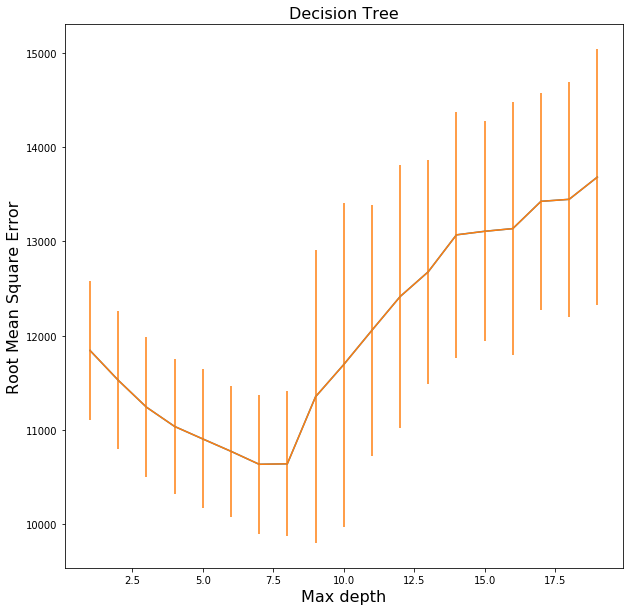

In [71]:
#plotting the results of the cross validation
#the error bars are standard deviation of the root mean squared error
#mse = root mean squared error :/
#Best fit seems to be occuring at a max depth of 8
plt.figure(figsize = (10,10))
plt.plot(np.linspace(1,19,19).ravel(),mse_mean.ravel())
plt.errorbar(np.linspace(1,19,19), mse_mean, yerr=mse_stdev)
plt.xlabel('Max depth',fontsize=16)
plt.ylabel('Root Mean Square Error', fontsize=16)
plt.title('Decision Tree',fontsize=16)
plt.show()

In [72]:
#Testing the same data with Random Forest
depth_scores = np.empty((5,5))

for i in range(1,6,1):
    rfr = RandomForestRegressor(n_estimators=100,max_depth=5*i)
    depth_scores[i-1] = list(np.sqrt(-cross_val_score(rfr, X_train_prp, y_train, scoring="neg_mean_squared_error", cv=5)))
mse_mean = np.mean(depth_scores, axis=1)
mse_stdev = np.std(depth_scores, axis=1)


KeyboardInterrupt: 

In [12]:
#Plotting the forest
plt.figure(figsize = (10,10))
plt.plot(np.linspace(1,20,20).ravel(),mse_mean.ravel())
plt.errorbar(np.linspace(1,20,20), mse_mean, yerr=mse_stdev)
plt.xlabel('Max depth',fontsize=16)
plt.ylabel('Root Mean Square Error', fontsize=16)
plt.title('Random Forest',fontsize=16)
plt.show()

NameError: name 'mse_mean' is not defined

<Figure size 720x720 with 0 Axes>

## Moving on to regressing the features onto normalized biomass

In [3]:
#Loading the data complete with strata
county_tree_cat = pd.read_csv('county_tree_climate_cats_DMH.csv')
county_tree_cat.head()

,Unnamed: 0,year,state_code,county_code,species,latitude,longitude,volume,Biomass,number_trees,mean_temp,mean_dwp,mean_prcp,phys_class_code,grow_class_code
0,0,2001,1,1,loblolly pine,32.578953,-86.593001,580.837421,12112.015753,148,67.470830,54.867025,0.153781,2.0,3.0
1,1,2001,1,1,red maple,32.620470,-86.587013,7.226856,182.733664,3,68.050000,54.900915,0.158415,2.0,3.0
2,2,2001,1,1,slash pine,32.515568,-86.626175,0.000000,16.737962,6,68.050000,54.900915,0.158415,2.0,3.0
3,3,2001,1,1,sweetgum,32.569998,-86.627121,161.481322,3499.375783,17,66.428324,54.806024,0.145440,2.0,3.0
4,4,2001,1,1,yellow-poplar,32.638274,-86.539808,35.165761,806.265958,8,68.050000,54.900915,0.158415,2.0,3.0


In [7]:
#Normalizing the volume and biomass to number of trees
county_tree_cat = county_tree_cat.assign(mean_volume = lambda x: x.volume/x.number_trees)
county_tree_cat = county_tree_cat.assign(mean_biomass = lambda x: x.Biomass/x.number_trees)

In [9]:
county_tree_cat.head()

,Unnamed: 0,year,state_code,county_code,species,latitude,longitude,volume,Biomass,number_trees,mean_temp,mean_dwp,mean_prcp,phys_class_code,grow_class_code,mean_volume,mean_biomass,log_biomass
0,0,2001,1,1,loblolly pine,32.578953,-86.593001,580.837421,12112.015753,148,67.470830,54.867025,0.153781,2.0,3.0,3.924577,81.837944,4.404741
1,1,2001,1,1,red maple,32.620470,-86.587013,7.226856,182.733664,3,68.050000,54.900915,0.158415,2.0,3.0,2.408952,60.911221,4.109417
2,2,2001,1,1,slash pine,32.515568,-86.626175,0.000000,16.737962,6,68.050000,54.900915,0.158415,2.0,3.0,0.000000,2.789660,1.025920
3,3,2001,1,1,sweetgum,32.569998,-86.627121,161.481322,3499.375783,17,66.428324,54.806024,0.145440,2.0,3.0,9.498901,205.845634,5.327127
4,4,2001,1,1,yellow-poplar,32.638274,-86.539808,35.165761,806.265958,8,68.050000,54.900915,0.158415,2.0,3.0,4.395720,100.783245,4.612972


## Preprocessing data

In [12]:
pipe = Pipeline([('scaler', Scaler(['latitude','longitude','mean_temp','mean_dwp','mean_prcp'])),
                ('encoder', species_enc())])

In [17]:
X = county_tree_cat[['species','latitude','longitude','mean_temp','mean_dwp','mean_prcp']]

In [18]:
yb = county_tree_cat['mean_biomass']

In [19]:
#train test split
X_train, X_test, y_train, y_test = train_test_split(X, yb, test_size = 0.3, shuffle = True, random_state = 42)

In [20]:
#transformation pipeline
X_train_prp = pipe.fit_transform(X_train)
y_train = y_train.to_numpy()

/home/dan/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/dan/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


In [97]:
#Cross validating for the decision tree
depth_scores = np.empty((19,5))

for i in range(2,21,1):
    dtr = DecisionTreeRegressor(max_depth=i)
    depth_scores[i-2] = list(np.sqrt(-cross_val_score(dtr, X_train_prp, y_train, scoring="neg_mean_squared_error", cv=5)))
mse_mean = np.mean(depth_scores, axis=1)
mse_stdev = np.std(depth_scores, axis=1)


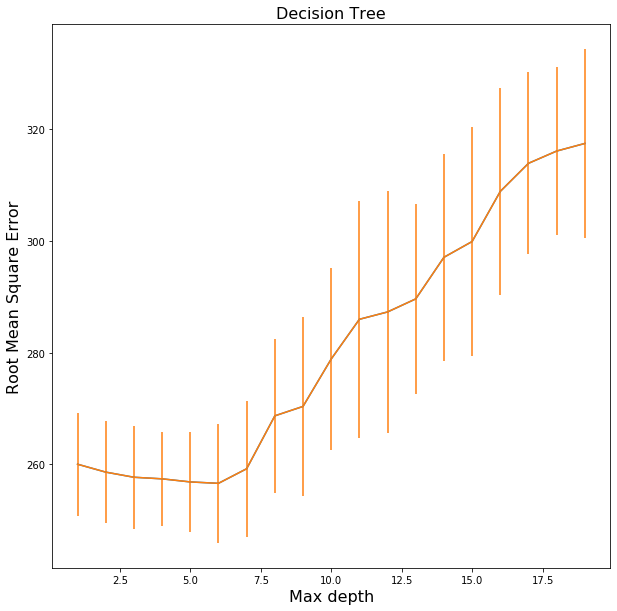

In [98]:
plt.figure(figsize = (10,10))
plt.plot(np.linspace(1,19,19).ravel(),mse_mean.ravel())
plt.errorbar(np.linspace(1,19,19), mse_mean, yerr=mse_stdev)
plt.xlabel('Max depth',fontsize=16)
plt.ylabel('Root Mean Square Error', fontsize=16)
plt.title('Decision Tree',fontsize=16)
plt.show()

In [99]:
#CV for the Random forest
depth_scores = np.empty((5,5))

for i in range(1,6,1):
    rfr = RandomForestRegressor(n_estimators=100,max_depth=5*i)
    depth_scores[i-1] = list(np.sqrt(-cross_val_score(rfr, X_train_prp, y_train, scoring="neg_mean_squared_error", cv=5)))
mse_mean = np.mean(depth_scores, axis=1)
mse_stdev = np.std(depth_scores, axis=1)


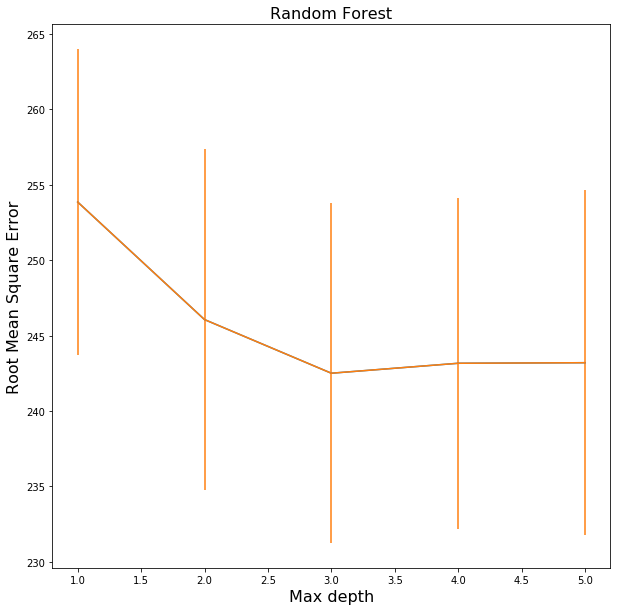

In [100]:
plt.figure(figsize = (10,10))
plt.plot(np.linspace(1,5,5).ravel(),mse_mean.ravel())
plt.errorbar(np.linspace(1,5,5), mse_mean, yerr=mse_stdev)
plt.xlabel('Max depth',fontsize=16)
plt.ylabel('Root Mean Square Error', fontsize=16)
plt.title('Random Forest',fontsize=16)
plt.show()

## Modeling with the addition of strata

In [3]:
#Loading the data complete with strata
county_tree_cat = pd.read_csv('county_tree_climate_cats_DMH.csv')
county_tree_cat.head()

,Unnamed: 0,year,state_code,county_code,species,latitude,longitude,volume,Biomass,number_trees,mean_temp,mean_dwp,mean_prcp,phys_class_code,grow_class_code
0,0,2001,1,1,loblolly pine,32.578953,-86.593001,580.837421,12112.015753,148,67.470830,54.867025,0.153781,2.0,3.0
1,1,2001,1,1,red maple,32.620470,-86.587013,7.226856,182.733664,3,68.050000,54.900915,0.158415,2.0,3.0
2,2,2001,1,1,slash pine,32.515568,-86.626175,0.000000,16.737962,6,68.050000,54.900915,0.158415,2.0,3.0
3,3,2001,1,1,sweetgum,32.569998,-86.627121,161.481322,3499.375783,17,66.428324,54.806024,0.145440,2.0,3.0
4,4,2001,1,1,yellow-poplar,32.638274,-86.539808,35.165761,806.265958,8,68.050000,54.900915,0.158415,2.0,3.0


In [7]:
#Normalizing the volume and biomass to number of trees
county_tree_cat = county_tree_cat.assign(mean_volume = lambda x: x.volume/x.number_trees)
county_tree_cat = county_tree_cat.assign(mean_biomass = lambda x: x.Biomass/x.number_trees)

In [103]:
#Pipeline that includes an encoder for strata
pipe = Pipeline([('scaler', Scaler(['latitude','longitude','mean_temp','mean_dwp','mean_prcp'])),
                ('encoder', enc())])

In [105]:
#Train test split and preprocessing
yb = county_tree_cat['mean_biomass']
X_train, X_test, y_train, y_test = train_test_split(X, yb, test_size = 0.3, shuffle = True, random_state = 42)
X_train_prp = pipe.fit_transform(X_train)
y_train = y_train.to_numpy()

/home/dan/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/dan/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


In [106]:
#CV for Decision tree
max_depth = 20
depth_scores = np.empty((19,5))

for i in range(2,21,1):
    dtr = DecisionTreeRegressor(max_depth=i)
    depth_scores[i-2] = list(np.sqrt(-cross_val_score(dtr, X_train_prp, y_train, scoring="neg_mean_squared_error", cv=5)))
mse_mean = np.mean(depth_scores, axis=1)
mse_stdev = np.std(depth_scores, axis=1)


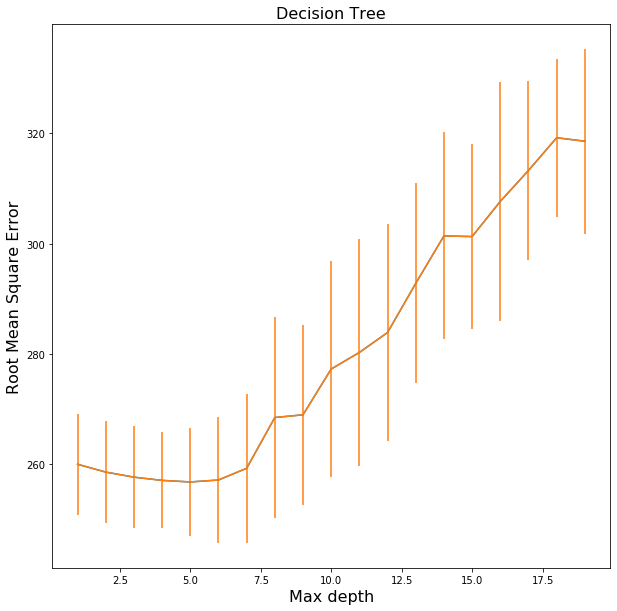

In [107]:
plt.figure(figsize = (10,10))
plt.plot(np.linspace(1,19,19).ravel(),mse_mean.ravel())
plt.errorbar(np.linspace(1,19,19), mse_mean, yerr=mse_stdev)
plt.xlabel('Max depth',fontsize=16)
plt.ylabel('Root Mean Square Error', fontsize=16)
plt.title('Decision Tree',fontsize=16)
plt.show()

In [101]:
#CV for random forest
max_depth = 20
depth_scores = np.empty((5,5))

for i in range(1,6,1):
    rfr = RandomForestRegressor(n_estimators=100,max_depth=5*i)
    depth_scores[i-1] = list(np.sqrt(-cross_val_score(rfr, X_train_prp, y_train, scoring="neg_mean_squared_error", cv=5)))
mse_mean = np.mean(depth_scores, axis=1)
mse_stdev = np.std(depth_scores, axis=1)


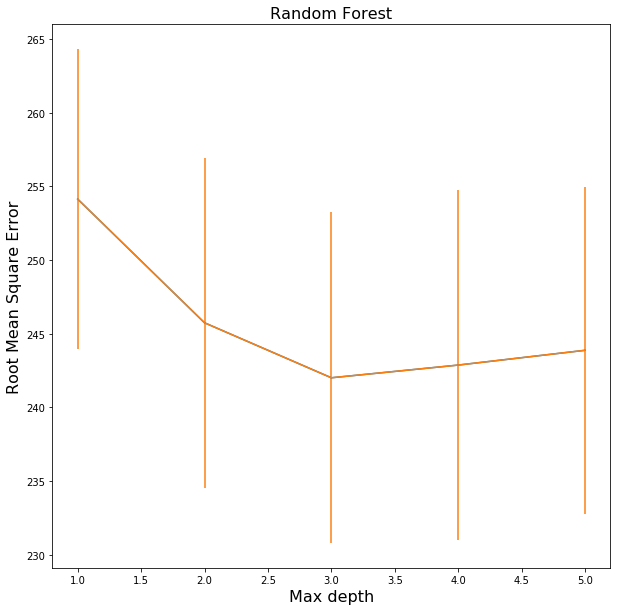

In [102]:
plt.figure(figsize = (10,10))
plt.plot(np.linspace(1,5,5).ravel(),mse_mean.ravel())
plt.errorbar(np.linspace(1,5,5), mse_mean, yerr=mse_stdev)
plt.xlabel('Max depth',fontsize=16)
plt.ylabel('Root Mean Square Error', fontsize=16)
plt.title('Random Forest',fontsize=16)
plt.show()

## Searching for best parameters for the Random forest with the log of biomass

In [11]:
#Loading the data complete with strata
county_tree_cat = pd.read_csv('county_tree_climate_cats_DMH.csv')
county_tree_cat.head()

,Unnamed: 0,year,state_code,county_code,species,latitude,longitude,volume,Biomass,number_trees,mean_temp,mean_dwp,mean_prcp,phys_class_code,grow_class_code
0,0,2001,1,1,loblolly pine,32.578953,-86.593001,580.837421,12112.015753,148,67.470830,54.867025,0.153781,2.0,3.0
1,1,2001,1,1,red maple,32.620470,-86.587013,7.226856,182.733664,3,68.050000,54.900915,0.158415,2.0,3.0
2,2,2001,1,1,slash pine,32.515568,-86.626175,0.000000,16.737962,6,68.050000,54.900915,0.158415,2.0,3.0
3,3,2001,1,1,sweetgum,32.569998,-86.627121,161.481322,3499.375783,17,66.428324,54.806024,0.145440,2.0,3.0
4,4,2001,1,1,yellow-poplar,32.638274,-86.539808,35.165761,806.265958,8,68.050000,54.900915,0.158415,2.0,3.0


In [12]:
#Normalizing the volume and biomass to number of trees
county_tree_cat = county_tree_cat.assign(mean_volume = lambda x: x.volume/x.number_trees)
county_tree_cat = county_tree_cat.assign(mean_biomass = lambda x: x.Biomass/x.number_trees)
county_tree_cat['log_biomass']= np.log(county_tree_cat['mean_biomass'])

In [13]:
#importing the gridsearchCV
from sklearn.model_selection import GridSearchCV
#defining the gridsearch for various number of estimators and max depths
#param_grid = [{'n_estimators': [3, 10, 50, 100, 200], 'max_depth': [5,10,15,20,25]}]
param_grid = [{'n_estimators': [200,300,400], 'max_depth': [5,10,15,20,25]}]

In [38]:
rfr = RandomForestRegressor()

In [14]:
pipe = Pipeline([('scaler', Scaler(['latitude','longitude','mean_temp','mean_dwp','mean_prcp'])),
                ('encoder', enc())])

In [15]:
X = county_tree_cat[['species','latitude','longitude','mean_temp','mean_dwp','mean_prcp','phys_class_code','grow_class_code']]
yb = county_tree_cat['log_biomass']

In [16]:
X_train, X_test, y_train, y_test = train_test_split(X, yb, test_size=0.3, shuffle=True, random_state=42)

In [17]:
X_train_prp = pipe.fit_transform(X_train)

/home/dan/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/dan/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


In [43]:
#fitting to the grid search
grid_search = GridSearchCV(rfr, param_grid, cv=5,
                           scoring='neg_mean_squared_error')
grid_search.fit(X_train_prp,y_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=RandomForestRegressor(bootstrap=True, ccp_alpha=0.0,
                                             criterion='mse', max_depth=None,
                                             max_features='auto',
                                             max_leaf_nodes=None,
                                             max_samples=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             n_estimators=100, n_jobs=None,
                                             oob_score=False, random_state=None,
                                             verbose=0, warm_start=False),
             iid='deprecated', n_jo

In [45]:
#Best parameters
grid_search.best_params_

{'max_depth': 15, 'n_estimators': 400}

In [46]:
cvres = grid_search.cv_results_

In [47]:
#Plotting the results for the various depths
depth_scores = np.empty((5,5))
for i in range(1,6,1):
    rfr = RandomForestRegressor(n_estimators=200,max_depth=5*i)
    depth_scores[i-1] = list(np.sqrt(-cross_val_score(rfr, X_train_prp, y_train, scoring="neg_mean_squared_error", cv=5)))
mse_mean = np.mean(depth_scores, axis=1)
mse_stdev = np.std(depth_scores, axis=1)


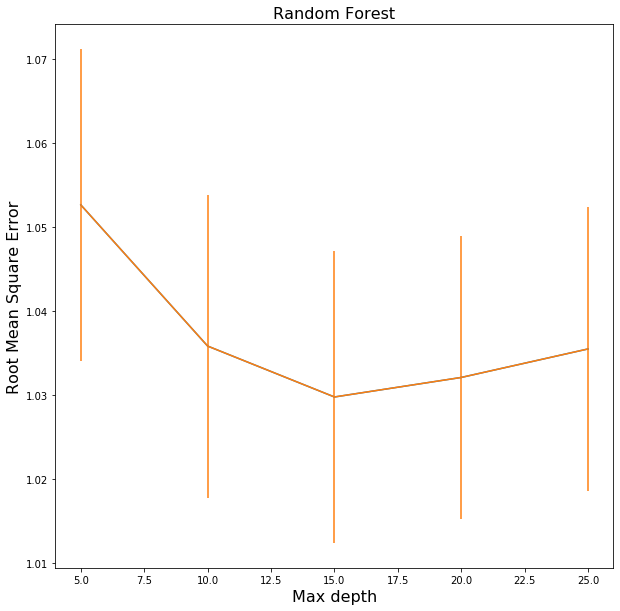

In [48]:
plt.figure(figsize = (10,10))
plt.plot(np.linspace(5,25,5).ravel(),mse_mean.ravel())
plt.errorbar(np.linspace(5,25,5), mse_mean, yerr=mse_stdev)
plt.xlabel('Max depth',fontsize=16)
plt.ylabel('Root Mean Square Error', fontsize=16)
plt.title('Random Forest',fontsize=16)
plt.show()

In [19]:
from sklearn.metrics import mean_squared_error

In [28]:
def plot_learning_curves(model, X, y):
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.9)
    train_errors, val_errors = [], []
    for m in range(1, len(X_train)):
        model.fit(X_train[:m], y_train[:m])
        y_train_predict = model.predict(X_train[:m])
        y_val_predict = model.predict(X_val)
        train_errors.append(mean_squared_error(y_train_predict, y_train[:m]))
        val_errors.append(mean_squared_error(y_val_predict, y_val))
    plt.plot(np.sqrt(train_errors), "r-+", linewidth=2, label="train")
    plt.plot(np.sqrt(val_errors), "b-", linewidth=3, label="val")

In [30]:
rfr = RandomForestRegressor(n_estimators=20, max_depth=15)

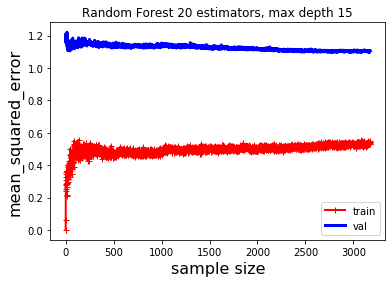

In [34]:
plot_learning_curves(rfr, X_train_prp, y_train)
plt.xlabel("sample size",fontsize=16)
plt.ylabel("mean_squared_error",fontsize=16)
plt.legend()
plt.title("Random Forest 20 estimators, max depth 15")
plt.show()